In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import math
import copy
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [21]:
np.random.seed(87+122)

In [22]:
# 1. Environment Description

# This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms:
# SARSA and Q-Learning. You will solve several variants of the Grid World problem (a sample
# world is shown in Figure 2).
# This is a grid world with 4 deterministic actions (‘up’, ‘down’, ‘left’, ‘right’). The agent transitions to the next state determined by the direction of the action chosen with a probability of
# p ∈ [0, 1]. We also define a parameter called b ∈ [0, 1]. Consider the direction of the action chosen
# as the agent’s “North”. For example, if the action is ‘left’, it is the agent’s North, and the agent’s
# East would be the direction of the action ‘up’. Figure 1 provides an illustration of the same. The
# agent transitions to the state West of the chosen action with probability (1−p)×b, and to the East
# of the chosen action with probability (1 − p) × (1 − b).
# The environment may also have a wind blowing that can push the agent one additional cell to the
# right after transitioning to the new state with a probability of 0.4. An episode is terminated
# either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the
# grid will not result in any change in state.
# The dimensions of the grid are 10 × 10. The following types of states exist:
# • Start state: The agent starts from this state.
# • Goal state: The goal is to reach one of these states. There are 3 goal states in total.
# • Obstructed state: These are walls that prevent entry to the respective cells. Transition to
# these states will not result in any change.
# • Bad state: Entry into these states will incur a higher penalty than a normal state.
# • Restart state: Entry into these states will incur a very high penalty and will cause agent to
# teleport to the start state without the episode ending. Once the restart state is reached, no
# matter what action is chosen, it goes to the start state at the next step.
# • Normal state: None of the above. Entry into these states will incur a small penalty.
# Rewards: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.


# 2. Additional Information
# The env.step() function takes as arguments
# the current state and action, and returns the reward and next state. The appropriate termination
# conditions have to be specified by the student in the code (as explained in section 1, env.reset ()
# resets the environment. In the notebook containing the code, cell 1 contains the environment class,
# cell 2 contains the environment instantiation, and cell 3 lists some environment variables. For each
# experiment, the start state is fixed and does not change. Different experiments may have different
# start states.


# 3. Tasks
# 1.  Implement SARSA and Q-Learning algorithms.
# For each algorithm, run experiments for the start states (0, 4) and (3, 6). Consider the following
# three variants of stochasticity for each start state.
# 1. wind=False(clear), p = 1.0(deterministic step).
# 2. wind=False(clear), p = 0.7(stochastic step).
# 3. wind=True(windy), p = 1.0(deterministic step).
# In total, you have to conduct 12 different experiments - (3 grid world variants × 2 start
# states × 2 algos).

# For each of the 12 experiments, determine the best set of hyperparameters({τ in softmax or
# ϵ in ϵ-greedy}, learning rate α, and discount factor γ), along with the best action selection
# policy(ϵ-greedy or softmax) with justification. You are also required to plot the following (4
# plots per exp) for each experiment(with the best hyperparameters and action selection policy):
# 1. Reward curves and the number of steps to reach the goal in each episode.
# 2. Heatmap of the grid with state visit counts, i.e., the number of times each state was
# visited throughout the training phase.
# 3. Heatmap of the grid with Q values after training is complete, and optimal actions for
# the best policy.

# Note: Each plot should be obtained by training the agent for at least 5000 episodes and
# the plots reported should be averaged over 5 runs. For the reward and steps plot, mean and
# standard deviation should be shown as in Figure 3. The mean values are denoted by the line
# graph and the shaded region above and below the line denotes the range of values within one
# standard deviation of the mean. For the heatmaps, it suffices to report mean state-visits and
# Q values.

# Code for the environment is provided in the next cell. You are required to implement the
# algorithms and the plots in the subsequent cells. You are free to add additional cells for
# implementation purposes.

## Environment

In [23]:
def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = math.floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [24]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [25]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [26]:
def init_env(start_state, p_good_transition, bias, wind):

    num_cols = 10
    num_rows = 10
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                            [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                            [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                            [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
    restart_states = np.array([[3,7],[8,2]])
    start_state = np.array([start_state])
    goal_states = np.array([[0,9],[2,2],[8,7]])
    
    gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states, wind = wind)
    gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=p_good_transition,
                                bias=bias)
    env = gw.create_gridworld()
    return env

##

In [27]:
# Parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
tau = 0.1

# Global Constants
num_episodes = 5000
num_runs = 5
max_steps = 100

## Policy

In [28]:
def softmax(Q, tau):
    Q = Q - np.max(Q)
    p = np.exp(Q/tau) / np.sum(np.exp(Q/tau))
    return np.random.choice(len(Q), p=p)

def epsilon_greedy(Q, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(len(Q))
    else:
        return np.argmax(Q)

In [29]:
class TDQLearner:
    def __init__(self, env, alpha, gamma, epsilon, tau, num_episodes, num_runs, policy='softmax'):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = tau
        self.num_episodes = num_episodes
        self.num_runs = num_runs
        self.policy = policy

    def _choose_action(self, Q):
        if self.policy == 'softmax':
            return softmax(Q, self.tau)
        elif self.policy == 'epsilon_greedy':
            return epsilon_greedy(Q, self.epsilon)
        else:
            raise Exception("Policy not recognized")
    
    def train(self):
        pass



class SARSA(TDQLearner):
    def train(self):
        rewards = np.zeros((self.num_runs, self.num_episodes))
        steps = np.zeros((self.num_runs, self.num_episodes))
        avg_Q = np.zeros((self.env.num_states, self.env.num_actions))
        state_visits = np.zeros((self.env.num_states, 1))

        for run in range(self.num_runs):
            Q = np.zeros((self.env.num_states, self.env.num_actions))
            for episode in tqdm(range(self.num_episodes), desc="Run: "+str(run+1), position=1):
                state = self.env.reset()
                done = False
                action = self._choose_action(Q[state, :])
                while not done:
                    next_state, reward = self.env.step(state, action)
                    next_action = self._choose_action(Q[next_state, :])

                    Q[state, action] += self.alpha * (reward + self.gamma * Q[next_state, next_action] - Q[state, action])

                    state = next_state
                    action = next_action
                    rewards[run, episode] += reward
                    steps[run, episode] += 1
                    state_visits[state] += 1
                    if state in self.env.goal_states_seq:
                        done = True
                    if steps[run, episode] > max_steps:
                        done = True
            avg_Q += Q

        avg_Q /= self.num_runs
        state_visits /= self.num_runs
        return avg_Q, rewards, steps, state_visits
    

    
class QLearning(TDQLearner):
    def train(self):
        rewards = np.zeros((self.num_runs, self.num_episodes))
        steps = np.zeros((self.num_runs, self.num_episodes))
        avg_Q = np.zeros((self.env.num_states, self.env.num_actions))
        state_visits = np.zeros((self.env.num_states, 1))

        for run in range(self.num_runs):
            Q = np.zeros((self.env.num_states, self.env.num_actions))
            for episode in tqdm(range(self.num_episodes), desc="Run: "+str(run+1), position=1):
                state = self.env.reset()
                done = False
                while not done:
                    action = self._choose_action(Q[state, :])
                    next_state, reward = self.env.step(state, action)

                    Q[state, action] += self.alpha * (reward + self.gamma * np.max(Q[next_state, :]) - Q[state, action])

                    state = next_state
                    rewards[run, episode] += reward
                    steps[run, episode] += 1
                    state_visits[state] += 1
                    if state in self.env.goal_states_seq:
                        done = True
                    if steps[run, episode] > max_steps:
                        done = True
            avg_Q += Q

        avg_Q /= self.num_runs
        state_visits /= self.num_runs
        return avg_Q, rewards, steps, state_visits


In [30]:
class OptimalPolicy:
    # Greedy policy based on Q values
    # returns the optimal_path and reward

    def __init__(self, env, Q):
        self.env = env
        self.Q = Q
        
    def run(self):
        optimal_actions = np.argmax(self.Q, axis=1)
        state = self.env.start_state_seq.item()
        path = [state]
        reward = 0
        while state not in self.env.goal_states_seq:
            action = optimal_actions[state]
            if action == 0:
                state -= self.env.num_cols
            elif action == 1:
                state += self.env.num_cols
            elif action == 2:
                state -= 1
            elif action == 3:
                state += 1

            path.append(state)
            reward += self.env.R[state]
        return path, reward
    
    def path(self):
        return self.run()[0]

    def reward(self):
        return self.run()[1]
    



# Hyperparameter tuning
def hyperparameter_tuning(env, algo, alphas, gammas, epsilons, taus, policy=None):
    # if policy is None, then both epsilon_greedy and softmax will be tuned
    # else we tune only for the specified policy

    best_reward = -np.inf
    best_mean_reward = -np.inf
    best_alpha = None
    best_gamma = None
    best_epsilon = None
    best_tau = None
    best_policy = None

    cnt = 0
    for alpha in alphas:
        for gamma in gammas:
            cnt += 1
            clear_output(wait=True)
            print(f"Progress: {cnt}/{len(alphas)*len(gammas)}")
            # policy = 'epsilon_greedy'
            if policy == 'epsilon_greedy' or policy is None:
                for epsilon in epsilons:
                    if algo == 'sarsa':
                        sarsa = SARSA(env, alpha, gamma, epsilon, 0, num_episodes, num_runs, policy='epsilon_greedy')
                        avg_Q, rewards, steps, state_visits = sarsa.train()
                    elif algo == 'qlearning':
                        qlearning = QLearning(env, alpha, gamma, epsilon, 0, num_episodes, num_runs, policy='epsilon_greedy')
                        avg_Q, rewards, steps, state_visits = qlearning.train()

                    opt_policy = OptimalPolicy(env, avg_Q)
                    reward = opt_policy.reward()
                    mean_reward = np.mean(rewards)

                    if reward > best_reward and mean_reward > best_mean_reward:
                        best_reward = reward
                        best_mean_reward = mean_reward
                        best_alpha = alpha
                        best_gamma = gamma
                        best_epsilon = epsilon
                        best_tau = 0
                        best_policy = 'epsilon_greedy'

            # policy = 'softmax'
            if policy == 'softmax' or policy is None:
                for tau in taus:
                    if algo == 'sarsa':
                        sarsa = SARSA(env, alpha, gamma, 0, tau, num_episodes, num_runs, policy='softmax')
                        avg_Q, rewards, steps, state_visits = sarsa.train()
                    elif algo == 'qlearning':
                        qlearning = QLearning(env, alpha, gamma, 0, tau, num_episodes, num_runs, policy='softmax')
                        avg_Q, rewards, steps, state_visits = qlearning.train()

                    opt_policy = OptimalPolicy(env, avg_Q)
                    reward = opt_policy.reward()
                    mean_reward = np.mean(rewards)

                    if reward > best_reward and mean_reward > best_mean_reward:
                        best_reward = reward
                        best_mean_reward = mean_reward
                        best_alpha = alpha
                        best_gamma = gamma
                        best_epsilon = 0
                        best_tau = tau
                        best_policy = 'softmax'

    return best_alpha, best_gamma, best_epsilon, best_tau, best_policy




In [37]:
import os
class Plot():
    def __init__(self, env, rewards, steps, state_visits, Q, save=False, exp=None):
        self.env = env
        self.rewards = rewards
        self.steps = steps
        self.state_visits = state_visits
        self.Q = Q
        self.save = save
        self.exp = exp #Experiment number

    def reward(self):
        mean_rewards = np.mean(self.rewards, axis=0)
        std_rewards = np.std(self.rewards, axis=0)
        plt.figure(figsize=(10, 6))
        plt.plot(mean_rewards, label="Mean Reward")
        plt.fill_between(range(len(mean_rewards)), mean_rewards-std_rewards, mean_rewards+std_rewards, alpha=0.3)
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Reward Curve")
        plt.legend()
        if self.save:
            os.makedirs(self.exp, exist_ok=True)
            plt.savefig(f"{self.exp}/reward.eps", format='eps')
        plt.show()
            

    def steps_to_goal(self):
        mean_steps = np.mean(self.steps, axis=0)
        std_steps = np.std(self.steps, axis=0)
        plt.figure(figsize=(10, 6))
        plt.plot(mean_steps, label="Mean Steps")
        plt.fill_between(range(len(mean_steps)), mean_steps-std_steps, mean_steps+std_steps, alpha=0.3)
        plt.xlabel("Episodes")
        plt.ylabel("Steps")
        plt.title("Steps to reach the goal")
        plt.legend()
        if self.save:
            plt.savefig(f"{self.exp}/steps.eps", format='eps')
        plt.show()

    def state_visit_count(self):
        state_visits = np.sum(self.state_visits, axis=1)
        plt.figure(figsize=(10,10))
        plt.imshow(state_visits.reshape(self.env.num_rows, self.env.num_cols), cmap='jet')
        plt.title("State Visits")
        plt.colorbar()
        if self.save:
            plt.savefig(f"{self.exp}/state_visits.eps", format='eps')
        plt.show()

    def Q_values(self):
        optimal_actions = np.argmax(self.Q, axis=1)
        
        plt.figure(figsize=(10,10))
        # Need to decide whether mean or max
        plt.imshow(np.max(self.Q, axis=1).reshape(self.env.num_rows, self.env.num_cols), cmap='jet')
        for state in range(self.env.num_states):
            row_col = seq_to_col_row(state, self.env.num_cols)
            cell_state = np.array([row_col[0,0], row_col[0,1]])
            if np.any(np.sum(np.abs(env.obs_states - cell_state), 1) == 0):
                plt.text(row_col[0,1], row_col[0,0], 'X', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            else:
                action = optimal_actions[state]
                if action == 0:
                    plt.arrow(row_col[0,1], row_col[0,0]+0.25, 0, -0.5, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)
                elif action == 1:
                    plt.arrow(row_col[0,1], row_col[0,0]-0.25, 0, 0.5, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)
                elif action == 2:
                    plt.arrow(row_col[0,1]+0.25, row_col[0,0], -0.5, 0, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)
                elif action == 3:
                    plt.arrow(row_col[0,1]-0.25, row_col[0,0], 0.5, 0, head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)
        plt.title("Q Values and Optimal Actions")
        plt.colorbar()
        if self.save:
            plt.savefig(f"{self.exp}/q_values.eps", format='eps')
        plt.show()

    def visualize_grid_world(self):
        grid = np.ones((self.env.num_rows, self.env.num_cols, 3))
        grid[self.env.obs_states[:,0], self.env.obs_states[:,1], :] = 0
        grid[self.env.bad_states[:,0], self.env.bad_states[:,1], 0] = 1
        grid[self.env.bad_states[:,0], self.env.bad_states[:,1], 1] = 0
        grid[self.env.bad_states[:,0], self.env.bad_states[:,1], 2] = 0
        grid[self.env.restart_states[:,0], self.env.restart_states[:,1], 0] = 0
        grid[self.env.restart_states[:,0], self.env.restart_states[:,1], 1] = 0
        grid[self.env.restart_states[:,0], self.env.restart_states[:,1], 2] = 1
        grid[self.env.goal_states[:,0], self.env.goal_states[:,1], 0] = 0
        grid[self.env.goal_states[:,0], self.env.goal_states[:,1], 1] = 1
        grid[self.env.goal_states[:,0], self.env.goal_states[:,1], 2] = 0
        grid[self.env.start_state[0,0], self.env.start_state[0,1], 0] = 1
        grid[self.env.start_state[0,0], self.env.start_state[0,1], 1] = 1
        grid[self.env.start_state[0,0], self.env.start_state[0,1], 2] = 0
        plt.figure(figsize=(8,8))
        plt.imshow(grid)

        for state in range(self.env.num_states):
            row_col = seq_to_col_row(state, self.env.num_cols)
            cell_state = np.array([row_col[0,0], row_col[0,1]])
            if np.any(np.sum(np.abs(env.obs_states - cell_state), 1) == 0):
                plt.text(row_col[0,1], row_col[0,0], 'X', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            if np.any(np.sum(np.abs(env.bad_states - cell_state), 1) == 0):
                plt.text(row_col[0,1], row_col[0,0], 'B', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            if np.any(np.sum(np.abs(env.restart_states - cell_state), 1) == 0):
                plt.text(row_col[0,1], row_col[0,0], 'R', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            if np.any(np.sum(np.abs(env.goal_states - cell_state), 1) == 0):
                plt.text(row_col[0,1], row_col[0,0], 'G', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
            if np.any(np.sum(np.abs(env.start_state - cell_state), 1) == 0):
                plt.text(row_col[0,1], row_col[0,0], 'S', ha='center', va='center', color='black', fontsize=12, fontweight='bold')
        
        if self.save:
            plt.savefig(f"{self.exp}/grid_world.eps", format='eps')


    def optimal_path(self):
        optimal_actions = np.argmax(self.Q, axis=1)
        state = self.env.start_state_seq.item()
        path = [state]
        done = False
        total_reward = 0
        while not done:
            action = optimal_actions[state]
            if action == 0:
                next_state = state - self.env.num_cols
            elif action == 1:
                next_state = state + self.env.num_cols
            elif action == 2:
                next_state = state - 1
            elif action == 3:
                next_state = state + 1

            state = next_state
            path.append(state)
            total_reward += self.env.R[state]
            if state in self.env.goal_states_seq:
                done = True

        self.visualize_grid_world()

        path_x = [seq_to_col_row(state, num_cols)[0, 1] for state in path]
        path_y = [seq_to_col_row(state, num_cols)[0, 0] for state in path]
        plt.plot(path_x, path_y, color='green', marker='', linestyle='--', linewidth=2)
        if self.save:
            plt.savefig(f"{self.exp}/optimal_path.eps", format='eps')
        plt.show()
        print(path)
        print("Total Reward", total_reward)

## Experiments

### Grid World 1

In [ ]:
env = init_env([0, 4], 1.0, 0.5, False)

# Hyperparameter tuning for SARSA
alphas = [0.1]
gammas = [0.9, 0.99]
epsilons = [0.1, 0.3, 0.5]
taus = [0.1, 0.3]

best_alpha, best_gamma, best_epsilon, best_tau, best_policy = hyperparameter_tuning(env, 'sarsa', alphas, gammas, epsilons, taus, policy='softmax')

clear_output(wait=True)

Best alpha: 0.1
Best gamma: 0.9
Best epsilon: 0
Best tau: 0.1
Best policy: softmax


In [ ]:
print("Best alpha:", best_alpha)
print("Best gamma:", best_gamma)
print("Best epsilon:", best_epsilon)
print("Best tau:", best_tau)
print("Best policy:", best_policy)

Best alpha: 0.1
Best gamma: 0.9
Best epsilon: 0
Best tau: 0.1
Best policy: softmax


Run: 5: 100%|██████████| 5000/5000 [00:10<00:00, 464.51it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


FileNotFoundError: [Errno 2] No such file or directory: '1.1.1/reward.eps'

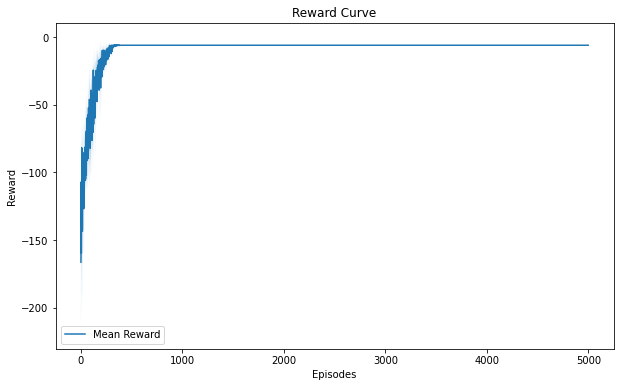

In [34]:
# Experiment 1.1.1: wind=False(clear), p = 1.0(deterministic step), start state (0, 4), SARSA
env = init_env([0, 4], 1.0, 0.5, False)

# Hyperparameter tuning
# will be done here

sarsa = SARSA(env, alpha, gamma, epsilon, tau, num_episodes, num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


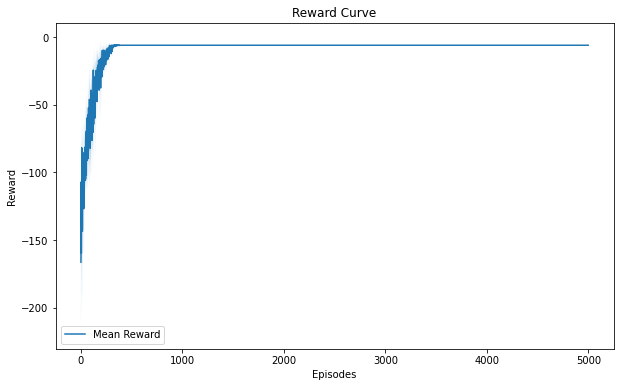

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


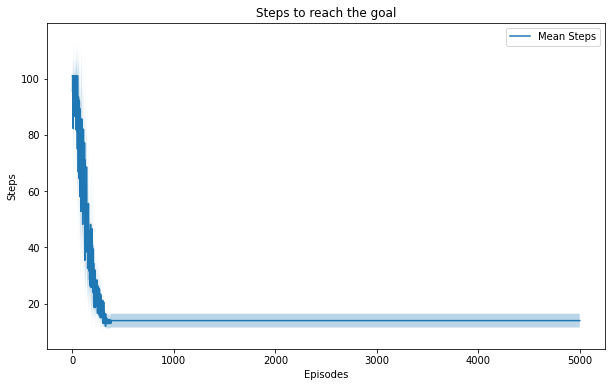

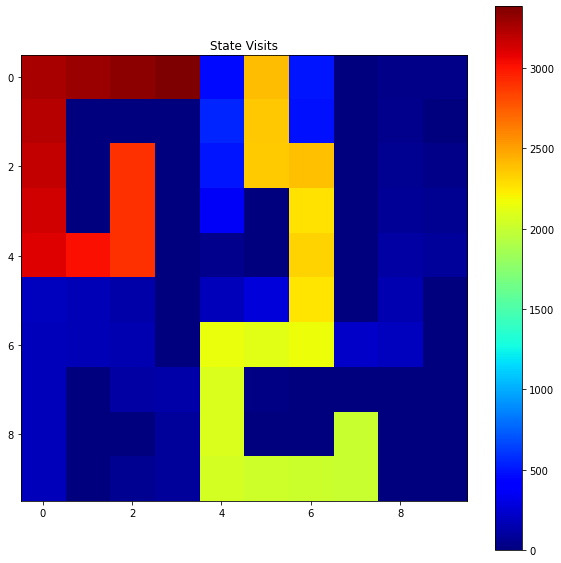

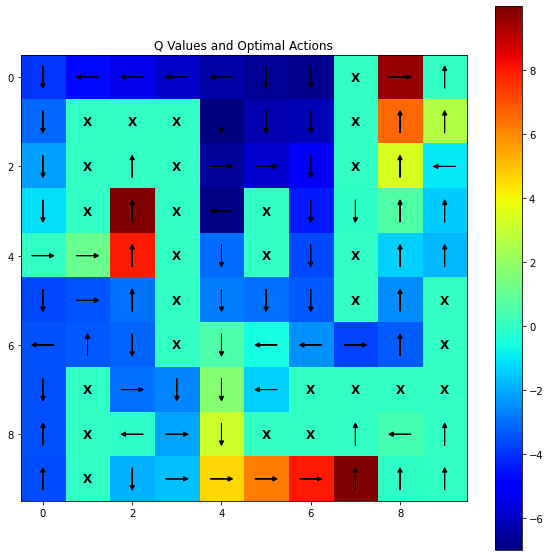

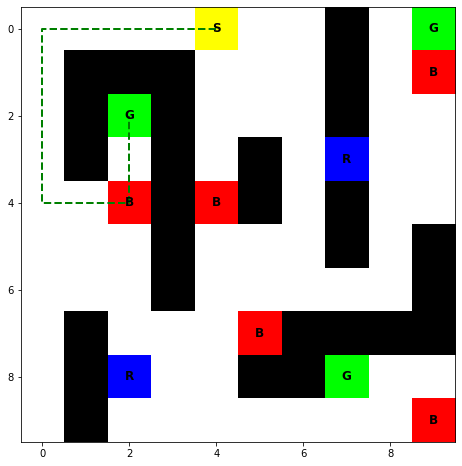

[4, 3, 2, 1, 0, 10, 20, 30, 40, 41, 42, 32, 22]
Total Reward [-6.]


In [38]:

plot = Plot(env, rewards, steps, state_visits, Q, save=True, exp="1.1.1")
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


Run: 5: 100%|██████████| 5000/5000 [00:16<00:00, 297.48it/s]


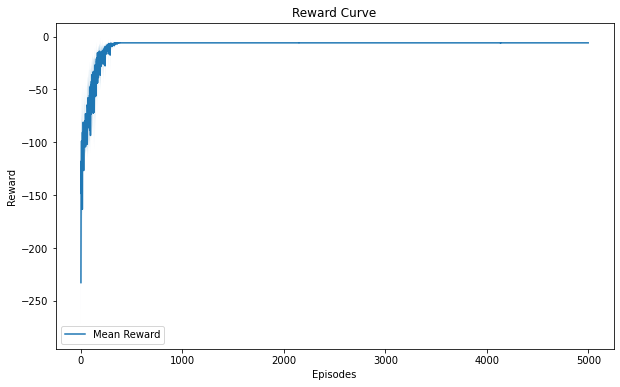

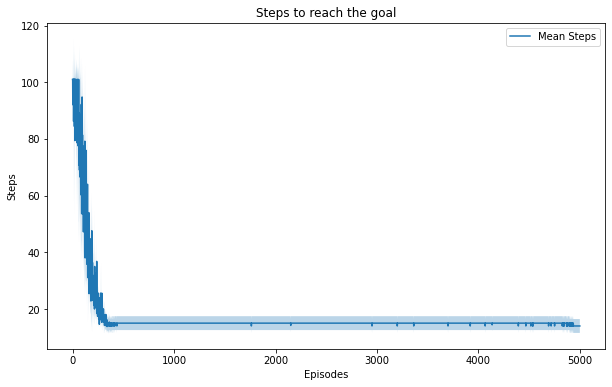

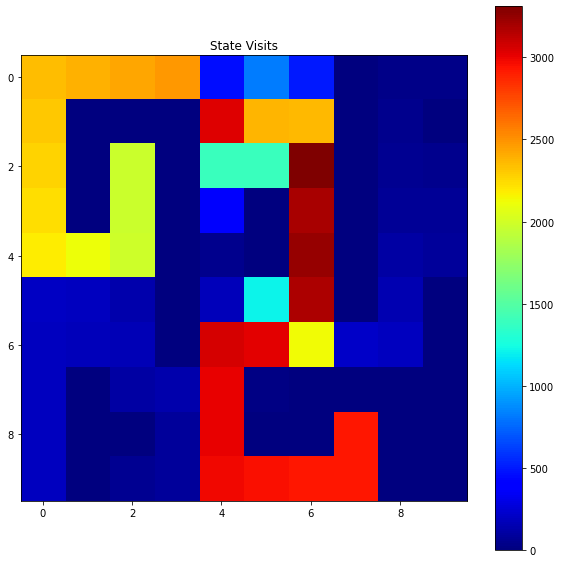

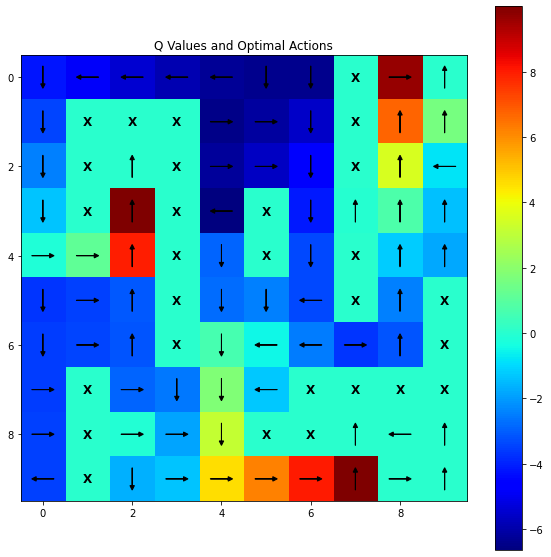

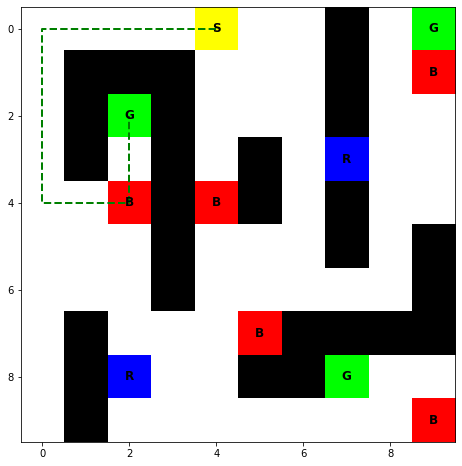

[4, 3, 2, 1, 0, 10, 20, 30, 40, 41, 42, 32, 22]
Total Reward [-6.]


In [ ]:
# Experiment 1.1.2: wind=False(clear), p = 1.0(deterministic step), start state (0, 4), Q-Learning
env = init_env([0, 4], 1.0, 0.5, False)

q_learning = QLearning(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()



In [ ]:
# Experiment 1.2.1: wind=False(clear), p = 1.0(deterministic step), start state (3, 6), SARSA
env = init_env([3, 6], 1.0, 0.5, False)

sarsa = SARSA(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


In [ ]:
# Experiment 1.2.2: wind=False(clear), p = 1.0(deterministic step), start state (3, 6), Q-Learning
env = init_env([3, 6], 1.0, 0.5, False)

q_learning = QLearning(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


### Grid World 2

Run: 5: 100%|██████████| 5000/5000 [00:18<00:00, 276.70it/s]


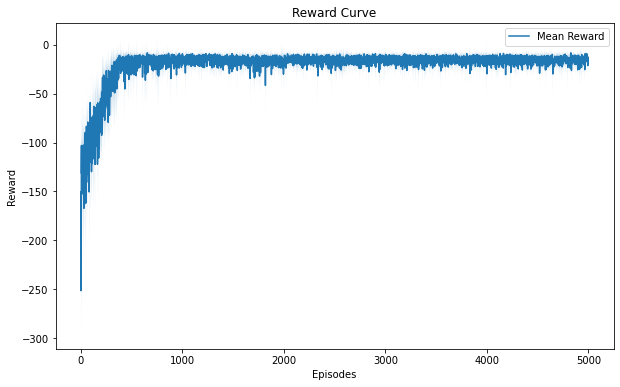

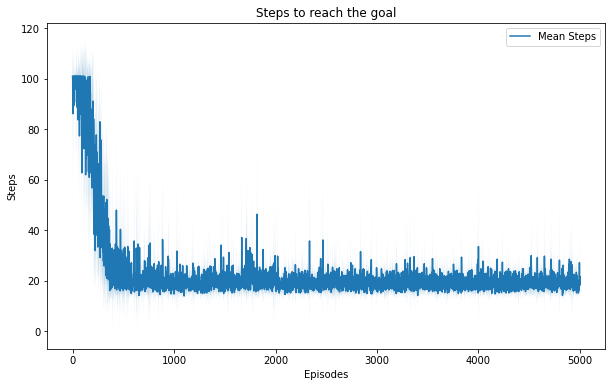

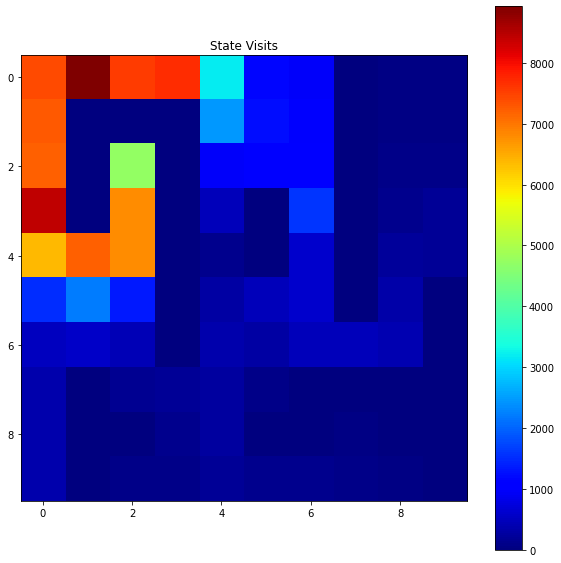

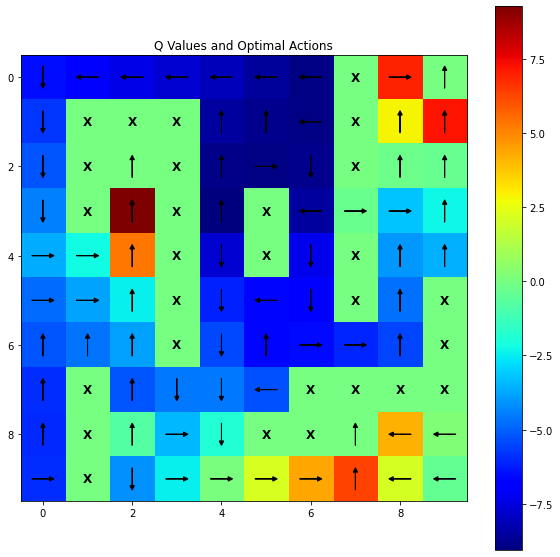

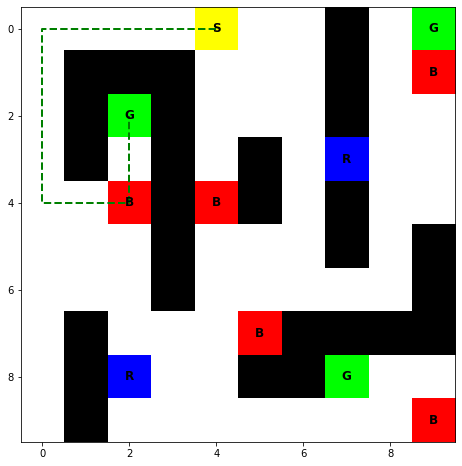

[4, 3, 2, 1, 0, 10, 20, 30, 40, 41, 42, 32, 22]
Total Reward [-6.]


In [ ]:
# Experiment 2.1.1: wind=False(clear), p = 0.7(stochastic step), start state (0, 4), SARSA
env = init_env([0, 4], 0.7, 0.5, False)

sarsa = SARSA(env, alpha, gamma, epsilon, tau, num_episodes, num_runs, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()

In [ ]:
# Experiment 2.1.2: wind=False(clear), p = 0.7(stochastic step), start state (0, 4), Q-Learning
env = init_env([0, 4], 0.7, 0.5, False)

q_learning = QLearning(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


In [ ]:
# Experiment 2.2.1: wind=False(clear), p = 0.7(stochastic step), start state (3, 6), SARSA
env = init_env([3, 6], 0.7, 0.5, False)

sarsa = SARSA(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


In [ ]:
# Experiment 2.2.2: wind=False(clear), p = 0.7(stochastic step), start state (3, 6), Q-Learning
env = init_env([3, 6], 0.7, 0.5, False)

q_learning = QLearning(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


### Grid World 3

In [ ]:
# Experiment 3.1.1: wind=True(windy), p = 1.0(deterministic step), start state (0, 4), SARSA
env = init_env([0, 4], 1.0, 0.5, True)

sarsa = SARSA(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


In [ ]:
# Experiment 3.1.2: wind=True(windy), p = 1.0(deterministic step), start state (0, 4), Q-Learning
env = init_env([0, 4], 1.0, 0.5, True)

q_learning = QLearning(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


In [ ]:
# Experiment 3.2.1: wind=True(windy), p = 1.0(deterministic step), start state (3, 6), SARSA
env = init_env([3, 6], 1.0, 0.5, True)

sarsa = SARSA(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = sarsa.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


In [ ]:
# Experiment 3.2.2: wind=True(windy), p = 1.0(deterministic step), start state (3, 6), Q-Learning
env = init_env([3, 6], 1.0, 0.5, True)

q_learning = QLearning(env, alpha=0.1, gamma=0.9, epsilon=0.1, tau=0.1, num_episodes=5000, num_runs=5, policy='softmax')
Q, rewards, steps, state_visits = q_learning.train()

plot = Plot(env, rewards, steps, state_visits, Q)
plot.reward()
plot.steps_to_goal()
plot.state_visit_count()
plot.Q_values()
plot.optimal_path()


## Crib

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
env.goal_states_seq
env.reset() in env.goal_states_seq

False

#### Sarsa
$$
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
$$

In [ ]:
# Hyperparameters
# Q = np.zeros((env.num_states, env.num_actions))
alpha = 0.1
gamma = 0.9
epsilon = 0.1
tau = 0.1
max_steps = 100

# SARSA
def sarsa_(env, num_episodes, alpha, gamma, epsilon=epsilon, tau=tau, choose_action=epsilon_greedy, Q_=None):
  print(alpha, gamma, epsilon, tau, num_episodes)
  rewards = []
  steps = []
  for episode in range(num_episodes):
    state = env.reset()
    action = choose_action(Q_[state, :], epsilon)
    done = False
    total_reward = 0
    total_steps = 0
    while not done:
      next_state, reward = env.step(state, action)
      total_reward += reward
      total_steps += 1

      next_action = choose_action(Q_[next_state, :], epsilon)

      # SARSA update
      Q_[state, action] += alpha * (reward + gamma * Q_[next_state, next_action] - Q_[state, action])
      
      state = next_state
      action = next_action
      done = (state in env.goal_states_seq) or (total_steps > max_steps)
    rewards.append(total_reward)
    steps.append(total_steps)
  return rewards, steps


#### Q-Learning

In [ ]:
def Q_Learning(env, num_episodes, alpha, gamma, epsilon=epsilon, tau=tau, choose_action=softmax, Q_=None):
  rewards = []
  steps = []
  for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    total_steps = 0
    while not done:
      # Epsilon-greedy action selection
      action = choose_action(Q_[state], tau)
      next_state, reward = env.step(state, action)
      total_reward += reward
      total_steps += 1
      # Q-Learning update
      Q_[state, action] += alpha * (reward + gamma * np.max(Q_[next_state]) - Q_[state, action])
      state = next_state
      done = (state in env.goal_states_seq) or (total_steps > max_steps)
    rewards.append(total_reward)
    steps.append(total_steps)
  return rewards, steps


#### Experiments

Run 5/5 complete


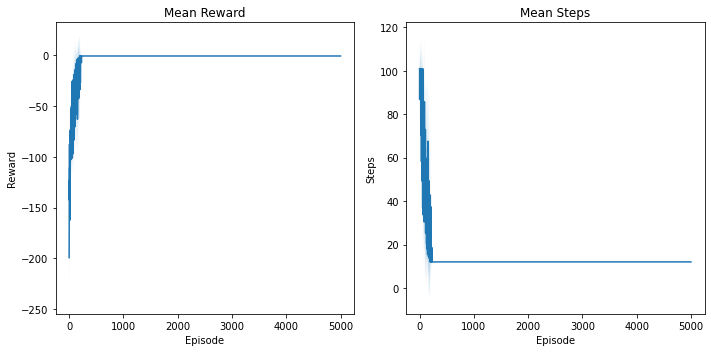

In [ ]:
# Run experiments for the start states (0, 4) and (3, 6). Consider the following three variants of stochasticity for each start state.
# 1. wind=False(clear), p = 1.0(deterministic step).
# we need :
#  Reward curves and the number of steps to reach the goal in each episode.
# 2. Heatmap of the grid with state visit counts, i.e., the number of times each state was
# visited throughout the training phase.
# 3. Heatmap of the grid with Q values after training is complete, and optimal actions for
# the best policy.


# Experiment 1

gw = GridWorld(num_rows=num_rows, num_cols=num_cols, start_state=start_state, goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions, bad_states=bad_states, restart_states=restart_states)
gw.add_rewards(step_reward=-1, goal_reward=10, bad_state_reward=-6, restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1.0, bias=0.5)
env = gw.create_gridworld()

# Initialization
num_runs = 5
num_episodes = 5000
alpha = 0.1
gamma = 0.9
epsilon = 0.1
tau = 0.1
# Q = np.zeros((env.num_states, env.num_actions))


rewards__ = np.zeros((num_runs, num_episodes))
steps__ = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
  Q__ = np.zeros((env.num_states, env.num_actions))
  rewards__[run, :], steps__[run, :] = sarsa_(env, num_episodes=num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon, tau=tau, choose_action=softmax, Q_=Q__)
  clear_output(wait=True)
  print(f"Run {run+1}/{num_runs} complete")

# Plot results
mean_rewards__ = np.mean(rewards__, axis=0)
std_rewards__ = np.std(rewards__, axis=0)
mean_steps__ = np.mean(steps__, axis=0)
std_steps__ = np.std(steps__, axis=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mean_rewards__)
plt.fill_between(range(num_episodes), mean_rewards__ - std_rewards__, mean_rewards__ + std_rewards__, alpha=0.3)
plt.title("Mean Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 2, 2)
plt.plot(mean_steps__)
plt.fill_between(range(num_episodes), mean_steps__ - std_steps__, mean_steps__ + std_steps__, alpha=0.3)
plt.title("Mean Steps")
plt.xlabel("Episode")
plt.ylabel("Steps")

plt.tight_layout()
plt.show()


Run: 5: 100%|██████████| 5000/5000 [00:12<00:00, 400.80it/s]


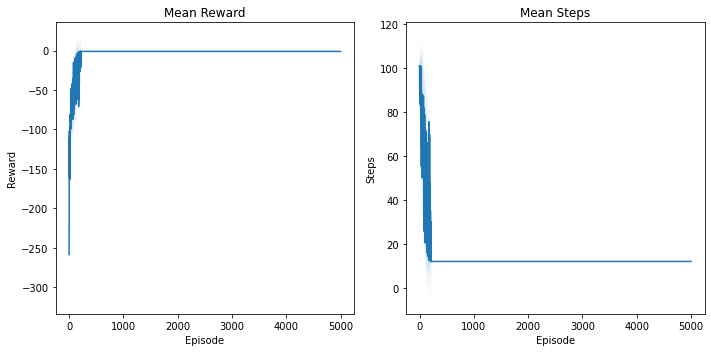

In [ ]:
# Experiment 1

gw = GridWorld(num_rows=num_rows, num_cols=num_cols, start_state=start_state, goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions, bad_states=bad_states, restart_states=restart_states)
gw.add_rewards(step_reward=-1, goal_reward=10, bad_state_reward=-6, restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1.0, bias=0.5)
env = gw.create_gridworld()

# Initialization
num_runs = 5
num_episodes = 5000
alpha = 0.1
gamma = 0.9
epsilon = 0.1
tau = 0.1


sarsa = SARSA(env, alpha, gamma, epsilon, tau, num_episodes, num_runs, policy='softmax')
Q, rewards, steps = sarsa.train()

mean_rewards = np.mean(rewards, axis=0)
std_rewards = np.std(rewards, axis=0)
mean_steps = np.mean(steps, axis=0)
std_steps = np.std(steps, axis=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mean_rewards)
plt.fill_between(range(num_episodes), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.3)
plt.title("Mean Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 2, 2)
plt.plot(mean_steps)
plt.fill_between(range(num_episodes), mean_steps - std_steps, mean_steps + std_steps, alpha=0.3)
plt.title("Mean Steps")
plt.xlabel("Episode")
plt.ylabel("Steps")

plt.tight_layout()
plt.show()



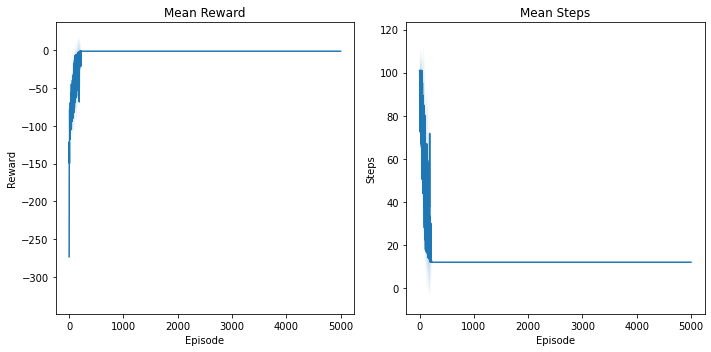

In [ ]:
gw = GridWorld(num_rows=num_rows, num_cols=num_cols, start_state=start_state, goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions, bad_states=bad_states, restart_states=restart_states)
gw.add_rewards(step_reward=-1, goal_reward=10, bad_state_reward=-6, restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1.0, bias=0.5)
env = gw.create_gridworld()

# Initialization
num_runs = 5
num_episodes = 5000
alpha = 0.1
gamma = 0.9
epsilon = 0.1
tau = 0.1


def Sarsa(env, num_episodes, alpha, gamma, epsilon=epsilon, tau=tau, choose_action=epsilon_greedy, Q=None):
    rewards = np.zeros((num_runs, num_episodes))
    steps = np.zeros((num_runs, num_episodes))
    avg_Q = np.zeros((env.num_states, env.num_actions))

    for run in range(num_runs):
        Q = np.zeros((env.num_states, env.num_actions))
        for episode in tqdm(range(num_episodes), desc="Run: "+str(run+1), position=1):
            state = env.reset()
            action = choose_action(Q[state, :], epsilon)
            done = False
            while not done:
                next_state, reward = env.step(state, action)
                next_action = choose_action(Q[next_state, :], epsilon)

                Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

                state = next_state
                action = next_action
                rewards[run, episode] += reward
                steps[run, episode] += 1
                if state in env.goal_states_seq:
                    done = True
                if steps[run, episode] > max_steps:
                    done = True
        avg_Q += Q

    avg_Q /= num_runs
    return avg_Q, rewards, steps

Q, rewards, steps = Sarsa(env, num_episodes, alpha, gamma, epsilon, tau, choose_action=softmax, Q=None)

mean_rewards = np.mean(rewards, axis=0)
std_rewards = np.std(rewards, axis=0)
mean_steps = np.mean(steps, axis=0)
std_steps = np.std(steps, axis=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mean_rewards)
plt.fill_between(range(num_episodes), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.3)
plt.title("Mean Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 2, 2)
plt.plot(mean_steps)
plt.fill_between(range(num_episodes), mean_steps - std_steps, mean_steps + std_steps, alpha=0.3)
plt.title("Mean Steps")
plt.xlabel("Episode")
plt.ylabel("Steps")

plt.tight_layout()
plt.show()


In [ ]:
stop

NameError: name 'stop' is not defined

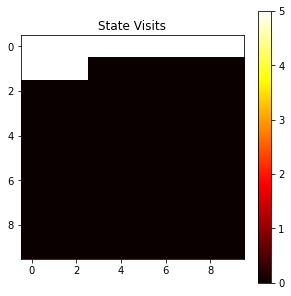

In [ ]:

# Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
state_visits = np.zeros((env.num_rows, env.num_cols))
for state in range(env.num_states):
  row_col = seq_to_col_row(state, env.num_cols)
  state_visits[row_col[0, 0], row_col[0, 1]] = np.sum(steps[:, -1] >= state)

plt.figure(figsize=(5, 5))
plt.imshow(state_visits, cmap="hot")
plt.title("State Visits")
plt.colorbar()
plt.show()


In [ ]:

# num_episodes = 5000
# num_runs = 5
# rewards = np.zeros((num_runs, num_episodes))
# steps = np.zeros((num_runs, num_episodes))
# for run in range(num_runs):
#   rewards[run], steps[run] = sarsa(env, num_episodes, alpha, gamma, epsilon, tau)
#   clear_output(wait=True)
#   print(f"Run {run+1}/{num_runs} complete")

# # Plot reward curves and the number of steps to reach the goal in each episode
# mean_rewards = np.mean(rewards, axis=0)
# std_rewards = np.std(rewards, axis=0)
# mean_steps = np.mean(steps, axis=0)
# std_steps = np.std(steps, axis=0)
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# plt.plot(mean_rewards)
# plt.fill_between(range(num_episodes), mean_rewards + std_rewards, mean_rewards - std_rewards, alpha=0.5)
# plt.title("Reward")
# plt.xlabel("Episode")
# plt.ylabel("Total Reward")
# plt.subplot(1, 2, 2)
# plt.plot(mean_steps)
# plt.fill_between(range(num_episodes), mean_steps + std_steps, mean_steps - std_steps, alpha=0.5)
# plt.title("Steps")
# plt.xlabel("Episode")
# plt.ylabel("Total Steps")
# plt.show()


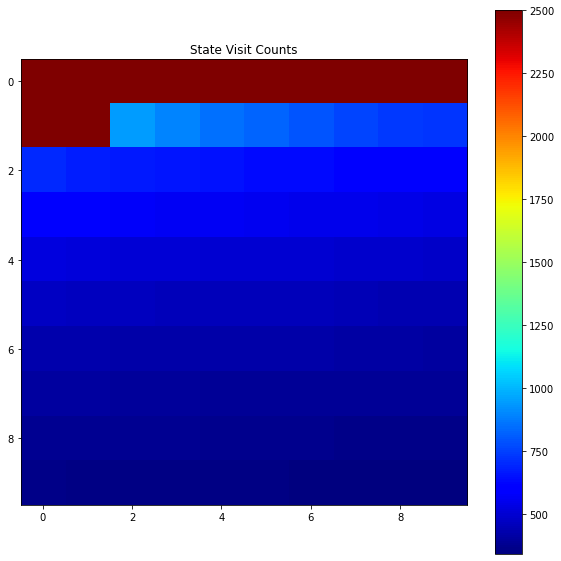

In [ ]:

# Heatmap of the grid with state visit counts
visit_counts = np.zeros((num_rows, num_cols))
for state in range(env.num_states):
  row_col = seq_to_col_row(state, num_cols)
  visit_counts[row_col[0, 0], row_col[0, 1]] = np.sum([1 for step in steps.flatten() if step > state])
plt.figure(figsize=(10, 10))
plt.imshow(visit_counts, cmap='jet', interpolation='none')
plt.title("State Visit Counts")
plt.colorbar()
plt.show()



In [ ]:
print(env.obs_states[0])

[0 7]


In [ ]:
state = 7
row_col = seq_to_col_row(state, env.num_cols)
# make cell_state of type env.obs_states[0] so that it can be compared with env.obs_states
cell_state = np.array([row_col[0,0], row_col[0,1]])
print(cell_state)
# check if cell_state is in env.obs_states
if np.any(np.sum(np.abs(env.obs_states - cell_state), 1) == 0):
    print("yes")
else:
    print("no")

[0 7]
yes


In [ ]:
seq_to_col_row(99, 10)

array([[9, 9]])

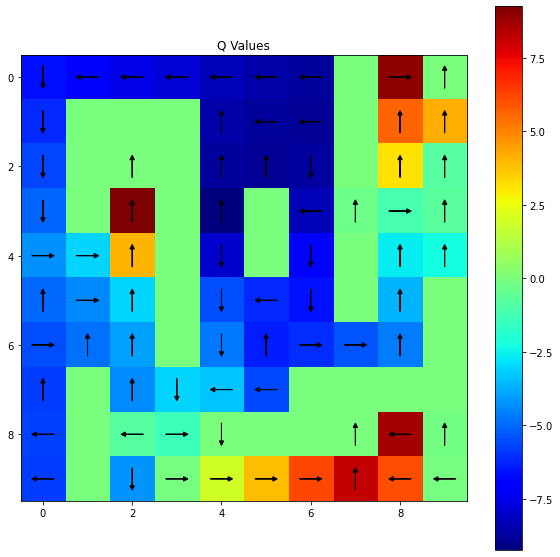

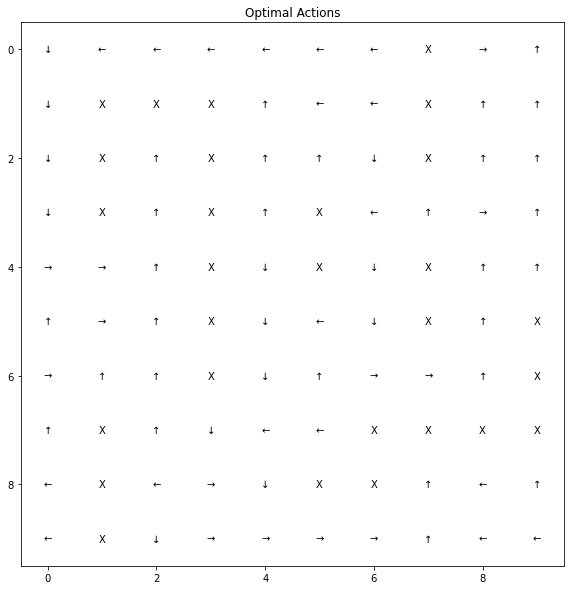

In [ ]:
# Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy
# mark arrow directions for optimal actions
optimal_actions = np.argmax(Q, axis=1)
optimal_action_dir = np.array([["" for _ in range(env.num_cols)] for _ in range(env.num_rows)])
# print(optimal_actions)
# print(optimal_action_dir)
for state in range(env.num_states):
    row_col = seq_to_col_row(state, env.num_cols)
    cell_state = np.array([row_col[0, 0], row_col[0, 1]])
    if np.any(np.sum(np.abs(env.obs_states - cell_state), 1) == 0):
        optimal_action_dir[row_col[0, 0], row_col[0, 1]] = "X"
    else:
        action = optimal_actions[state]
        if action == 0:
            optimal_action_dir[row_col[0, 0], row_col[0, 1]] = "↑"
        elif action == 1:
            optimal_action_dir[row_col[0, 0], row_col[0, 1]] = "↓"
        elif action == 2:
            optimal_action_dir[row_col[0, 0], row_col[0, 1]] = "←"
        elif action == 3:
            optimal_action_dir[row_col[0, 0], row_col[0, 1]] = "→"

# Heatmap of the grid with Q values along with optimal_action_dir
plt.figure(figsize=(10, 10))
plt.imshow(np.max(Q, axis=1).reshape(num_rows, num_cols), cmap='jet')
# for i in range(num_rows):
#     for j in range(num_cols):
#         plt.text(j, i, optimal_action_dir[i, j], ha='center', va='center', color='black')

for i in range(num_rows):
    for j in range(num_cols):
        action = optimal_action_dir[i, j]
        if action == "↑":
            plt.arrow(j, i+0.25, 0, -0.5, head_width=0.1, head_length=0.1, color='black', length_includes_head=True)
        elif action == "↓":
            plt.arrow(j, i-0.25, 0, 0.5, head_width=0.1, head_length=0.1, color='black', length_includes_head=True)
        elif action == "←":
            plt.arrow(j+0.25, i, -0.5, 0, head_width=0.1, head_length=0.1, color='black', length_includes_head=True)
        elif action == "→":
            plt.arrow(j-0.25, i, 0.5, 0, head_width=0.1, head_length=0.1, color='black', length_includes_head=True)


plt.title("Q Values")
plt.colorbar()
plt.show()

# Plot only optimal_action_dir on a white background grid
plt.figure(figsize=(10, 10))
plt.imshow(np.ones((num_rows, num_cols, 3)))
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, optimal_action_dir[i, j], ha='center', va='center', color='black')
plt.title("Optimal Actions")
plt.show()



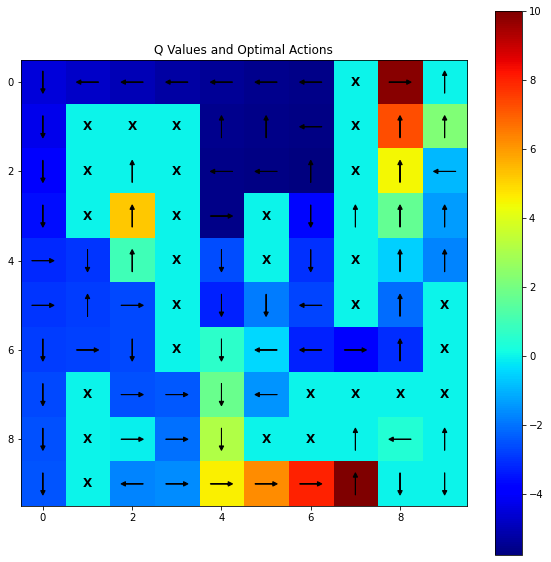

In [ ]:
# Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy
# mark arrow directions for optimal actions
# use Plot class

plot = Plot(env, rewards, steps, Q)
plot.Q_values()


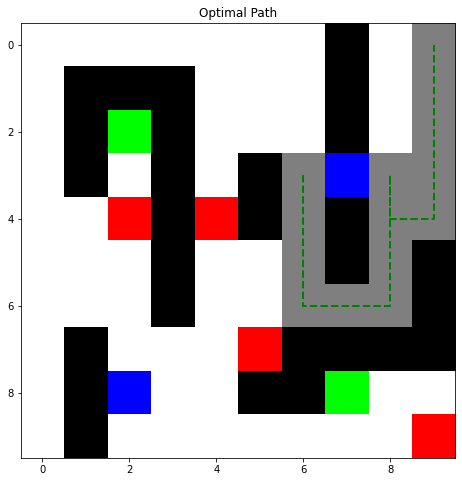

In [ ]:
# Plot the optimal path from the start state to the goal state
state = env.start_state_seq.item()
path = [state]
done = False
while not done:
    action = optimal_actions[state]
    next_state, _ = env.step(state, action)
    path.append(next_state)
    state = next_state
    done = (state in env.goal_states_seq)


# Plot the path on the grid
grid = np.ones((num_rows, num_cols, 3))
grid[obstructions[:,0], obstructions[:,1], :] = 0
grid[bad_states[:,0], bad_states[:,1], 0] = 1
grid[bad_states[:,0], bad_states[:,1], 1] = 0
grid[bad_states[:,0], bad_states[:,1], 2] = 0
grid[restart_states[:,0], restart_states[:,1], 0] = 0
grid[restart_states[:,0], restart_states[:,1], 1] = 0
grid[restart_states[:,0], restart_states[:,1], 2] = 1
grid[goal_states[:,0], goal_states[:,1], 0] = 0
grid[goal_states[:,0], goal_states[:,1], 1] = 1
grid[goal_states[:,0], goal_states[:,1], 2] = 0
grid[start_state[0,0], start_state[0,1], 0] = 1
grid[start_state[0,0], start_state[0,1], 1] = 1
grid[start_state[0,0], start_state[0,1], 2] = 0
for state in path:
    row_col = seq_to_col_row(state, num_cols)
    grid[row_col[0, 0], row_col[0, 1], :] = 0.5
plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.title("Optimal Path")

path_x = [seq_to_col_row(state, num_cols)[0, 1] for state in path]
path_y = [seq_to_col_row(state, num_cols)[0, 0] for state in path]
plt.plot(path_x, path_y, color='green', marker='', linestyle='--', linewidth=2)

plt.show()



In [ ]:
steps[0][1]

101.0